### Feature Selection with Annealing
This algorithm improves performance by selecting the k most influential features and discarding the rest.  
This is done with an annealing schedle $\{M_e\}$, which is a sequence that detemrines how many features are dropped at each set.
At each iteration e, the weights are updated with gradient descent, and the $M_e$ features with the least significant weights are dropped.
The annealing schedule used here is: $$M_e = k + (M-k)\times max(0,\frac{N-2e}{2e\mu+N})$$
where N is the total number of iterations, M is the original number of features, k is the desired number of features in the final model, and $\mu$ is a parameter that controls the "cooling rate".
Feature Selection with Annealing for Computer
Vision and Big Data Learning
Adrian Barbu, Yiyuan She, Liangjing Ding, Gary Gramajo
available at https://arxiv.org/abs/1310.2880

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from Load_data import load_data

For this example we will use the 'Lorenz loss' function: $$l(x) = \begin{cases}0 & x> 1\\ln(1+(x-1)^2) & x\leq 1\end{cases}$$ 

In [2]:
def Lorenz(x):
    L = np.nan_to_num(np.log(1+(x[x < 1]-1)**2))
    return L

In addition to the Lorenz loss, we incude an $L^2$ regularisation penalty $p(x) = s\sum^m_i x_i^2$, so the final loss is 
$$L(y,X,\beta)=\sum_i^N l(y_ix_i^T\beta) + s\sum_j^M \beta_j^2$$

In [3]:
def Loss(y,X,b,s):
    bx = np.dot(X,b)
    return np.sum(Lorenz(y*bx))/len(y) +s*(np.linalg.norm(b)**2)

In order to minimize the loss, we need the gradient $$\frac{\delta L}{\delta \beta} = \frac{X^T(2y*(y*X\beta-1)}{1+(y*X\beta)^2}+2s\beta$$ where $y*X\beta \leq 1$ and 0 elsewhere. (here * means element-wise multiplication)

In [12]:
def dfLoss(y,X,b,s):
    ybx = np.array(y*np.dot(X,b))
    ybx1 = np.ones(np.shape(ybx))
    ybx1[ybx<= 1]=ybx[ybx<= 1]
    delt =np.zeros(np.shape(b))
    delt = np.dot(X.T,y*2*(ybx1-1)/(1+(ybx1-1)**2))/len(y) + 2*s*b
    return delt.astype(float)

In [13]:
#load training and test data
train,train_label,test,test_label=load_data("Data\\gisette_train.data","Data\\gisette_train.labels","Data\\gisette_valid.data","Data\\gisette_valid.labels")


In [14]:
train_label[train_label==0]=-1
test_label[test_label==0]=-1

In [15]:
#Initialize parameters
N=500
eta = 5
mu= 100
s=0.001
k=[10,30,100,300] # k is the final number of desired parameters
lenk = len(k)
#Calculate annealing schedule
u=(N-2*np.arange(0,N))/(2*mu*np.arange(0,N)+N)
v = np.zeros(N)
v[u>=0]=u[u>=0]
#initialize prediction and loss dataframes
train_pred = np.zeros((len(train_label),lenk))
test_pred = np.zeros((len(test_label),lenk))
Losse = np.zeros((N,lenk))

In [41]:
for j in range(lenk):   #loop through different values for k
    beta =np.zeros((train.shape[1],1)) #initialise weights at zero
    M1 = (k[j]+(np.shape(beta)[0]-k[j])*v).astype(int) #Get annealing schedule for ur vale of k
    M = np.append(0,np.diff(M1)+1)

    #At each step we remove all the discarded features from the design matrix to speed up calculation
    train1=train
    test1=test

    for i in np.arange(0,N):
        #Update weights by grad. descent
        beta1 = beta - eta*dfLoss(train_label,train1,beta,s) 
        #Select features to keep based  on largest weights
        keep = np.argsort(beta1**2,axis=0)[-M1[i]:].flatten()
        #discard nwanted features from weights and design matrix
        beta = beta1[keep]
        train1=train1[:,keep]
        test1=test1[:,keep]
        #record loss
        Losse[i,j]=Loss(train_label,train1,beta,s)
    
    #get predictions on train and test set
    train_pred[:,j] = (np.dot(train1,beta)>0).flatten()
    test_pred[:,j] = (np.dot(test1,beta)>0).flatten()
    
    
    
tl =np.tile(train_label==1,lenk)
train_error = np.sum(train_pred!=tl,axis=0)/len(train_label)

vl =np.tile(test_label==1,lenk)
test_error = np.sum(test_pred!=vl,axis=0)/len(test_label)

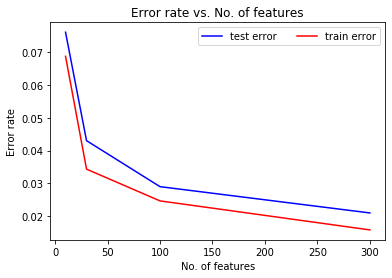

In [43]:
#Plot the training and test error
plt.plot(k,test_error,'b-',label='test error',)
plt.plot(k,train_error,'r-',label='train error',)
plt.title('Error rate vs. No. of features')
plt.xlabel('No. of features')
plt.ylabel('Error rate')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame()